Plot u, v velocity on the horizontal plane

# Determine time period for an ebb tide given a day 

In [1]:
from __future__ import division

from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from salishsea_tools.nowcast import figures
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
import scipy.io as sio
import datetime
import glob
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests

In [2]:
%matplotlib inline

In [3]:
SITES = {
    'Point Atkinson': {
        'lat': 49.33,
        'lon': -123.25,
        'msl': 3.09,
        'stn_no': 7795,
        'extreme_ssh': 5.61},
    'Victoria': {
        'lat': 48.41,
        'lon': -123.36,
        'msl': 1.8810,
        'stn_no': 7120,
        'extreme_ssh': 3.76},
    'Campbell River': {
        'lat': 50.04,
        'lon': -125.24,
        'msl': 2.916,
        'stn_no': 8074,
        'extreme_ssh': 5.35},
    'Neah Bay': {
        'lat': 48.4,
        'lon': -124.6,
        'stn_no':  9443090},
    'Friday Harbor': {
        'lat': 48.55,
        'lon': -123.016667,
        'stn_no': 9449880},
    'Cherry Point': {
        'lat': 48.866667,
        'lon': -122.766667,
        'stn_no': 9449424},
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30},
    'Tofino': {
        'stn_no': 8615},
    'VENUS': {
        'East': {
            'lat': 49.0419,
            'lon': -123.3176,
            'depth': 170},
        'Central': {
            'lat': 49.0401,
            'lon': -123.4261,
            'depth': 300}
        }
    }

In [4]:
def ebb_tide_time(grid_T, stn_name, PST , MSL = 0):
    "Determine ebb tide start time and end time in PST or UTC at\
    a given day at stations we got our tidal preditions"
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_T)
    ttide = figures.get_tides(stn_name)
    time = ttide.time + PST * time_shift
    ssh = ttide.pred_all + SITES[stn_name]['msl'] * MSL
    for i in np.arange(len(ttide)):
        
        if (ttide.time[i].year == t_orig.year) & (ttide.time[i].month == t_orig.month)\
        & (ttide.time[i].day == t_orig.day):
            if (ssh[i] - ssh[i-1] >0) & (ssh[i] - ssh[i+1] >0):
                ebb_tide_start = ttide.time[i].hour
            
            if (ssh[i] - ssh[i-1] <0) & (ssh[i] - ssh[i+1] <0): 
                ebb_tide_end = ttide.time[i].hour
    if PST ==0:
        print "ebb tide begins at " + str(ebb_tide_start) +  ", ends at "\
        + str(ebb_tide_end) + " UTC time"
    else:
        print "ebb tide begins at " + str(ebb_tide_start) +  ", ends at "\
        + str(ebb_tide_end) + " PST time"
    return ebb_tide_start, ebb_tide_end  

In [5]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [6]:
run_date = datetime.datetime(2015,6,15)
# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [8]:
from glob import glob

In [9]:
grid_T = results_dataset('1h', 'grid_T', results_dir)

In [10]:
start, end = ebb_tide_time(grid_T, 'Point Atkinson', PST = 0, MSL = 0)

ebb tide begins at 11, ends at 19 UTC time


# plot u, v quiver during ebb tide in the model coordinate system

In [11]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
grid_U_hr = results_dataset('1h', 'grid_U', results_dir)
grid_V_hr = results_dataset('1h', 'grid_V', results_dir)
grid_W_hr = results_dataset('1h', 'grid_W', results_dir)

In [12]:
lat =grid_U_hr.variables['nav_lat'] ## for U grid
lon =grid_U_hr.variables['nav_lon']
zlevels = grid_U_hr.variables['depthu']
lats =grid_T_hr.variables['nav_lat'] ## for T grid
lons =grid_T_hr.variables['nav_lon']
timesteps = grid_U_hr.variables['time_counter']
u = grid_U_hr.variables['vozocrtx']
v = grid_V_hr.variables['vomecrty']
w = grid_W_hr.variables['vovecrtz']

# Velocity quiver plot 

In [9]:
bathy = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

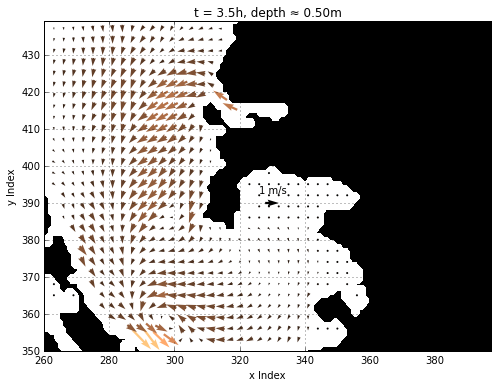

In [11]:
t, zlevel = 3, 0
y_slice = np.arange(350, 440)
x_slice = np.arange(260, 398)

arrow_step = 3
y_slice_a = y_slice[::arrow_step]
x_slice_a = x_slice[::arrow_step]

u_masked = np.ma.masked_values(u[t, zlevel, y_slice_a, x_slice_a], 0)
v_masked = np.ma.masked_values(v[t, zlevel, y_slice_a, x_slice_a], 0)
u_masked, v_masked = viz_tools.unstagger(u_masked, v_masked)
speeds = np.sqrt(np.square(u_masked) + np.square(v_masked))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
viz_tools.set_aspect(ax)
quiver = ax.quiver(
    x_slice_a[1:], y_slice_a[1:], u_masked, v_masked, speeds,
    pivot='mid', cmap='copper', width=0.005)
viz_tools.plot_land_mask(ax, bathy, xslice=x_slice, yslice=y_slice)

ax.set_xlim(x_slice[0], x_slice[-1])
ax.set_ylim(y_slice[0], y_slice[-1])
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=t+0.5\
                                                            , d=zlevels[zlevel], z=zlevels))
ax.quiverkey(quiver, 330, 390, 1, '1 m/s', coordinates='data', color='black', labelcolor='black')

# Change the coordinate

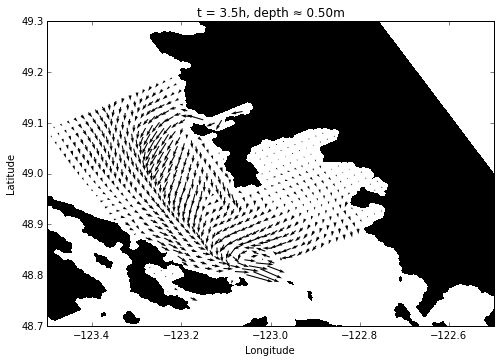

In [23]:
t, zlevel = 3, 0
step = 3
y_slice = np.arange(350, 440)
x_slice = np.arange(260, 398)

lats_slice = lats[350 : 440, 260 : 398]
lons_slice = lons[350 : 440, 260 : 398]

theta=29
theta_rad=29 * np.pi / 180

u_masked = np.ma.masked_values(u[t, zlevel, y_slice, x_slice], 0)
v_masked = np.ma.masked_values(v[t, zlevel, y_slice, x_slice], 0)
u_masked, v_masked = viz_tools.unstagger(u_masked, v_masked)

u_E=u_masked * np.cos(theta_rad) - v_masked * np.sin(theta_rad)
v_N=u_masked * np.sin(theta_rad) + v_masked * np.cos(theta_rad)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
viz_tools.set_aspect(ax)

ax.quiver(lons_slice[1::3, 1::3], lats_slice[1::3, 1::3], u_E[::3,::3], v_N[::3,::3])
viz_tools.plot_land_mask(ax, bathy, coords='map', color='k')

ax.set_xlim([-123.5, -122.5])
ax.set_ylim([48.7, 49.3])
#ax.grid()

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(u't = {t:.1f}h, depth \u2248 {d:.2f}{z.units}'.format(t=t+0.5,\
                                                    d=zlevels[zlevel], z=zlevels))